Using *RNN* + other classifiers

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocessing function to map emoticons to integer values
def preprocess_emoticons(train_path, test_path):
    """
    Preprocess the input emoticons in the dataset by creating a unique integer mapping
    for each distinct emoticon. This function returns preprocessed train and test datasets
    along with the emoticon-to-integer mapping.

    Args:
    train_path (str): Path to the training dataset CSV file.
    test_path (str): Path to the test dataset CSV file.

    Returns:
    train_input (pd.DataFrame): Preprocessed training dataset with mapped integers.
    test_data (pd.DataFrame): Preprocessed test dataset with mapped integers.
    emoticon_to_int (dict): Mapping from emoticons to unique integers.
    """
    # Load train and test datasets
    train_input = pd.read_csv(train_path)  # Assuming 'input_emoticon' and 'labels' columns
    test_data = pd.read_csv(test_path)  # Assuming test_data has similar structure

    # Step 1: Extract all unique emoticons from the training dataset
    all_emoticons = ''.join(train_input['input_emoticon'].values)
    unique_emoticons = sorted(set(all_emoticons))  # Sort for consistent mapping

    # Step 2: Create the emoticon to integer mapping
    emoticon_to_int = {emoticon: i for i, emoticon in enumerate(unique_emoticons)}

    # Step 3: Preprocessing function to map emoticons to their corresponding integer values
    def map_emoticons_to_int(emoticon_string):
        return [emoticon_to_int[emoticon] for emoticon in emoticon_string]

    # Apply the mapping to train and test datasets
    train_input['mapped_input'] = train_input['input_emoticon'].apply(map_emoticons_to_int)
    test_data['mapped_input'] = test_data['input_emoticon'].apply(map_emoticons_to_int)

    return train_input, test_data, emoticon_to_int

# Load and preprocess datasets
train_path = "/content/train_emoticon.csv"
test_path = "/content/valid_emoticon.csv"
train_input, test_data, emoticon_to_int = preprocess_emoticons(train_path, test_path)

# Extract features and labels
X_train_raw = train_input['mapped_input'].tolist()
y_train = train_input['label'].values
X_test_raw = test_data['mapped_input'].tolist()
y_test = test_data['label'].values

# Step 1: Pad sequences to ensure all have the same length (13 in this case)
max_length = 13  # Since each emoticon string is of length 13
X_train = pad_sequences(X_train_raw, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test_raw, maxlen=max_length, padding='post', truncating='post')

# Step 2: Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 3: Define hyperparameters and the model
vocab_size = len(emoticon_to_int)  # Number of unique emoticons
embedding_dim = 20
rnn_units = 48
sequence_length = max_length  # Length of each input sequence

# Build the RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
    SimpleRNN(rnn_units, activation='tanh'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Step 5: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Print the mapping for reference
print("\nEmoticon to Integer Mapping:\n", emoticon_to_int)

# Print validation accuracy per epoch
for epoch, val_acc in enumerate(history.history['val_accuracy']):
    print(f"Epoch {epoch + 1}: Validation Accuracy = {val_acc}")
print(model.summary())

# Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
y_val_pred = log_reg.predict(X_val)
log_reg_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression Validation Accuracy: {log_reg_accuracy}")

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_val_pred_rf = rf_clf.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Validation Accuracy: {rf_accuracy}")

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_val_pred_xgb = xgb_clf.predict(X_val)
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
print(f"XGBoost Validation Accuracy: {xgb_accuracy}")

# Step 3: Test set evaluation for all models
y_test_pred_log_reg = log_reg.predict(X_test)
log_reg_test_accuracy = accuracy_score(y_test, y_test_pred_log_reg)
print(f"Logistic Regression Test Accuracy: {log_reg_test_accuracy}")

y_test_pred_rf = rf_clf.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")

y_test_pred_xgb = xgb_clf.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, y_test_pred_xgb)
print(f"XGBoost Test Accuracy: {xgb_test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5808 - loss: 0.6570 - val_accuracy: 0.8679 - val_loss: 0.3689
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8903 - loss: 0.2857 - val_accuracy: 0.9258 - val_loss: 0.1974
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9360 - loss: 0.1738 - val_accuracy: 0.9336 - val_loss: 0.1624
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9503 - loss: 0.1337 - val_accuracy: 0.9484 - val_loss: 0.1326
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9598 - loss: 0.1087 - val_accuracy: 0.9407 - val_loss: 0.1361
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9650 - loss: 0.0920 - val_accuracy: 0.9548 - val_loss: 0.1132
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9756 - loss: 0.0692 - val_accuracy: 0.9527 - val_loss: 0.1218
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9773 - loss: 0.0637 - val_accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 13, 20)                │           4,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (32, 48)                    │           3,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,925 (89.55 KB)

 Trainable params: 7,641 (29.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,284 (59.71 KB)

None
Logistic Regression Validation Accuracy: 0.53954802259887
Random Forest Validation Accuracy: 0.5727401129943502


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Accuracy: 0.643361581920904
Logistic Regression Test Accuracy: 0.591002044989775
Random Forest Test Accuracy: 0.6380368098159509
XGBoost Test Accuracy: 0.6503067484662577


CNNs
Experiments in finetuning showed that
1. Using a smaller embedding size gave a better accuracy showing that it unnecessary complexity slowed the model.
2. Removing the dense layer and replacing it with flatten increased the accuracy (deep network not required)
3.Decreasing number of filters and number of epochs in conv increased accuracy
4. using maxpooling 1d with pool size=1 gave better accuract indicating that each feature was important
5. Using convolution multiple times increased the accurcy(captures spatial relations better)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

# def set_seed(seed_value=42):
#     np.random.seed(seed_value)
#     random.seed(seed_value)
#     tf.random.set_seed(seed_value)

vocab_size = len(emoticon_to_int)  # Number of unique emoticons
embedding_dim = 10
num_filters = 8
kernel_size = 3
sequence_length = max_length  # Length of each input sequence
# set_seed()

# Build the CNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    Flatten(),
    # Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the CNN model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=16)

# Step 5: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Print validation accuracy per epoch
for epoch, val_acc in enumerate(history.history['val_accuracy']):
    print(f"Epoch {epoch + 1}: Validation Accuracy = {val_acc}")
print(model.summary())

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5684 - loss: 0.6693 - val_accuracy: 0.8623 - val_loss: 0.3191
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8713 - loss: 0.3027 - val_accuracy: 0.9040 - val_loss: 0.2223
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9172 - loss: 0.2068 - val_accuracy: 0.9350 - val_loss: 0.1686
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9482 - loss: 0.1478 - val_accuracy: 0.9555 - val_loss: 0.1276
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9603 - loss: 0.1135 - val_accuracy: 0.9527 - val_loss: 0.1172
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9708 - loss: 0.0875 - val_accuracy: 0.9647 - val_loss: 0.0969
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9779 - loss: 0.0742 - val_accuracy: 0.9605 - val_loss: 0.0948
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9800 - loss: 0.0654 - val_accuracy: 0.9576 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (16, 13, 10)                │           2,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (16, 11, 8)                 │             248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (16, 9, 8)                  │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (16, 72)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (16, 1)                     │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,985 (31.20 KB)

 Trainable params: 2,661 (10.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,324 (20.80 KB)

None


integrating different models with the above cnn
---> meaning that the last layer of features in the cnn model was extracted out. These were proved to be very good features as using Logistic regression on these featrues yielded maximum accuracy

In [3]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

feature_extractor_cnn = Sequential(model.layers[:-1])  # Remove last Dense
train_cnn_features = feature_extractor_cnn.predict(X_train)
val_cnn_features = feature_extractor_cnn.predict(X_val)
test_cnn_features = feature_extractor_cnn.predict(X_test)

# Reuse the evaluate_classifier function to train classifiers on CNN-extracted features
def evaluate_classifier_cnn(clf, clf_name):
    # Train classifier on the extracted CNN features
    clf.fit(train_cnn_features, y_train)

    # Predict on the test set using the classifier
    y_pred = clf.predict(test_cnn_features)

    # Evaluate accuracy on the test set
    test_acc = accuracy_score(y_test, y_pred)
    print(f"{clf_name} on CNN-Extracted Features Test Accuracy: {test_acc:.4f}")

# 1. RandomForest Classifier on CNN features
rf_classifier = RandomForestClassifier(n_estimators=100)
evaluate_classifier_cnn(rf_classifier, "RandomForest")

# 2. XGBoost Classifier on CNN features
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_classifier_cnn(xgb_classifier, "XGBoost")

# 3. Logistic Regression Classifier on CNN features
logreg_classifier = LogisticRegression(max_iter=1000, C= 0.1, penalty= 'l2', solver='liblinear')
evaluate_classifier_cnn(logreg_classifier, "Logistic Regression")
n_params = logreg_classifier.coef_.size + logreg_classifier.intercept_.size
print(f"Number of parameters: {n_params}")

# 4. SVM Classifier on CNN features
svm_classifier = SVC(C=1, gamma = 'scale', kernel='linear')
evaluate_classifier_cnn(svm_classifier, "SVM")
n_support_vectors = svm_classifier.support_vectors_.shape[0]
print(f"Number of support vectors: {n_support_vectors}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RandomForest on CNN-Extracted Features Test Accuracy: 0.9611


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:49:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on CNN-Extracted Features Test Accuracy: 0.9632
Logistic Regression on CNN-Extracted Features Test Accuracy: 0.9611
Number of parameters: 73
SVM on CNN-Extracted Features Test Accuracy: 0.9591
Number of support vectors: 119


Accuracy with different splits


Training with 20% of the training data...
Validation Accuracy with 20% training data: 0.8517

Training with 40% of the training data...
Validation Accuracy with 40% training data: 0.9117

Training with 60% of the training data...
Validation Accuracy with 60% training data: 0.9336

Training with 80% of the training data...
Validation Accuracy with 80% training data: 0.9555

Training with 100% of the training data...
Validation Accuracy with 100% training data: 0.9718


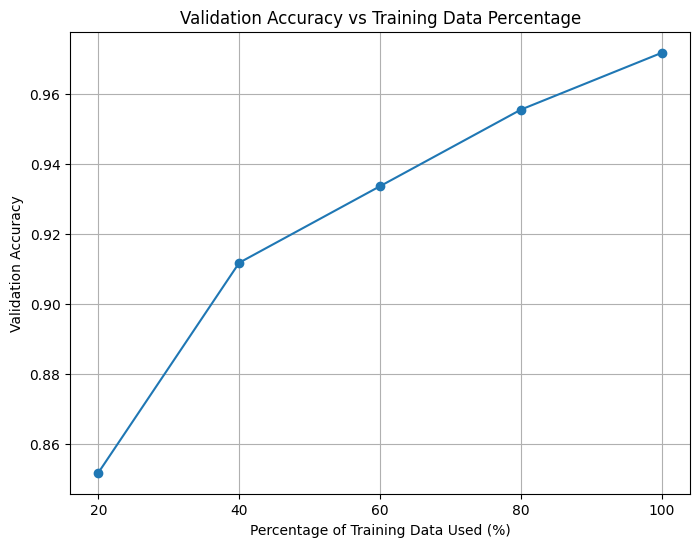

In [5]:
import matplotlib.pyplot as plt  # Import for plotting

# Define the percentages of training data to use
training_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
validation_accuracies = []

# Use your existing training and validation data
X_train_full = X_train
y_train_full = y_train

# Loop over different training percentages
for pct in training_percentages:
    print(f"\nTraining with {int(pct * 100)}% of the training data...")
    # Determine the number of samples to use
    num_samples = int(len(X_train_full) * pct)
    X_train_subset = X_train_full[:num_samples]
    y_train_subset = y_train_full[:num_samples]

    # Build and compile your model (e.g., CNN)
    # Adjust the model architecture as per your earlier code
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the subset
    history = model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)

    # Get the last validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    validation_accuracies.append(val_accuracy)
    print(f"Validation Accuracy with {int(pct * 100)}% training data: {val_accuracy:.4f}")

# Plot validation accuracy vs percentage of training data
plt.figure(figsize=(8,6))
plt.plot([int(pct * 100) for pct in training_percentages], validation_accuracies, marker='o')
plt.title('Validation Accuracy vs Training Data Percentage')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Validation Accuracy')
plt.xticks([20, 40, 60, 80, 100])
plt.grid(True)
plt.show()


In [ ]:
def create_cnn_model(vocab_size, embedding_dim, sequence_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
        Conv1D(filters=8, kernel_size=3, activation='relu'),
        Conv1D(filters=8, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Function to train models on varying percentages of training data and test on the validation set
def validate_on_varying_data(percentages, model, X, y, X_val, y_val):
    val_accuracies_cnn, val_accuracies_logreg, val_accuracies_rf, val_accuracies_svm = [], [], [], []
    n_samples = len(X)

    for pct in percentages:
        # Define subset size for training data
        n_subset = int(n_samples * (pct / 100))
        X_train_subset = X[:n_subset]
        y_train_subset = y[:n_subset]

        # 1. Train CNN model
        model_copy = create_cnn_model(vocab_size, embedding_dim=10, sequence_length=max_length)
        model_copy.fit(X_train_subset, y_train_subset, epochs=5, batch_size=32, verbose=0)
        val_loss, val_acc_cnn = model_copy.evaluate(X_val, y_val, verbose=0)
        val_accuracies_cnn.append(val_acc_cnn)

        # Extract CNN features
        feature_extractor = Sequential(model_copy.layers[:-1])
        train_cnn_features = feature_extractor.predict(X_train_subset)
        val_cnn_features = feature_extractor.predict(X_val)

        # 2. Logistic Regression on CNN features
        logreg = LogisticRegression(max_iter=200)
        logreg.fit(train_cnn_features, y_train_subset)
        y_val_pred_logreg = logreg.predict(val_cnn_features)
        val_accuracies_logreg.append(accuracy_score(y_val, y_val_pred_logreg))

        # 3. Random Forest on CNN features
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_clf.fit(train_cnn_features, y_train_subset)
        y_val_pred_rf = rf_clf.predict(val_cnn_features)
        val_accuracies_rf.append(accuracy_score(y_val, y_val_pred_rf))

        # 4. SVM on CNN features
        svm_clf = SVC(kernel='linear', C=1)
        svm_clf.fit(train_cnn_features, y_train_subset)
        y_val_pred_svm = svm_clf.predict(val_cnn_features)
        val_accuracies_svm.append(accuracy_score(y_val, y_val_pred_svm))

    # Plotting validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(percentages, val_accuracies_cnn, label='CNN', marker='o')
    plt.plot(percentages, val_accuracies_logreg, label='CNN + Logistic Regression', marker='o')
    plt.plot(percentages, val_accuracies_rf, label='CNN + Random Forest', marker='o')
    plt.plot(percentages, val_accuracies_svm, label='CNN + SVM', marker='o')
    plt.xlabel('Percentage of Training Data')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Training Data Percentage for Different Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Define percentages of training data to experiment with
percentages = [20, 40, 60, 80, 100]

# Call the function
validate_on_varying_data(percentages, model, X_train, y_train, X_val, y_val)